# Main Analysis Pipeline
 
 * Prepare Hough transform based only on wire information (= energy, time, radial distance)
 * Build predictions based on Hough, local information, and local information of left/right neighbors 

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CyDetHits, CTHHits, CDCHits, FlatHits
from memory_profiler import memory_usage
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def flatten_data(data, keys, samples, n_features):
    return pandas.DataFrame(data=data[samples].reshape(-1, n_feats), columns=keys)

def mask(data, pol=None):
    if pol==None:
        return data[data['labels'] != 0]
    if pol==0:
        return data[(data['labels'] != 0) & (data['Polarity'] == 0)]
    if pol==1:
        return data[(data['labels'] != 0) & (data['Polarity'] != 0)]

def predict_classifier(classifier, data_samp):
    """
    Return predictions where no hit has zero response by definition.  Return both
    flat predictions, and event sorted predicitions
    """
    # Get the predictions
    pred_evt = classifier.predict_proba(data_samp)[:,1]

    # Check which wires have hits, which ones do not
    not_hit = (data_samp['labels'] == 0).values
    has_hit = (data_samp['labels'] != 0).values

    # Define hit-less wires as definitely not being signal
    pred_evt[not_hit] = 0

    # Slim down the result to a copy with only hits
    pred = pred_evt[has_hit]
    # Reshape the result to be the event shape, for the hoguh transform
    pred_evt = pred_evt.reshape(-1, geom.n_points)
    
    return pred, pred_evt

## Import Signal Hits

In [3]:
file_base = "/vols/comet00/users/elg112/ICEDUST"\
            "/local_storage/SimDetectorResponse_tree"\
            "/test_signal_sample/03000014_"
cdc_sig_file = file_base + "cdc_sum_sig.root"
cth_sig_file = file_base + "cth_mc_sig.root"

In [4]:
file_base = "/vols/comet00/users/elg112/ICEDUST"\
            "/local_storage/SimDetectorResponse_tree"\
            "/test_signal_sample/100k_"
cdc_sig_file = file_base + "cdc_sum_hits.root"
cth_sig_file = file_base + "cth_mc_hits.root"

In [5]:
these_branches = ["DriftTime","DriftDist"]

In [6]:
sig_cth = FlatHits(cth_sig_file,
                  tree="COMETEventsSummary",
                  signal_coding=[1], 
                  hit_type_name="IsSig",
                  prefix="CTHHit.f",
                  branches=["CTHHit.fMCPos.fE",
                            "CTHHit.fChannel",
                            "CTHHit.fCharge"])
print sig_cth.n_events

43087


In [7]:
sig_cdc = CyDetHits(cdc_sig_file, 
                      tree="COMETEventsSummary",
                      signal_coding=[1], 
                      hit_type_name="Track.fTrackID",
                      branches=these_branches)
print sig_cdc.n_events

52639


In [8]:
from cylinder import CyDet
geom = CyDet()
n_events = sig_cth.n_events

### Check some event numbers

In [9]:
from collections import Counter

In [10]:
print sig_cth.n_events
print len(np.unique(sig_cth.get_events()[sig_cth.key_name]))

43087
43087


99997
0
99997


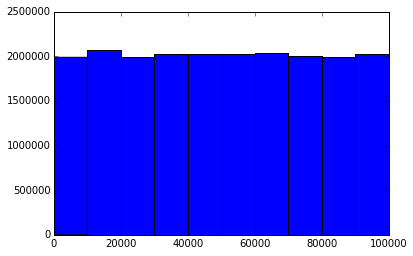

Counter({23134: 101})


In [11]:
event = 10000
plt.hist(sig_cth.get_events()[sig_cth.key_name])
print np.amax(sig_cth.get_events()[sig_cth.key_name])
print np.amin(sig_cth.get_events()[sig_cth.key_name])
print np.amax(sig_cth.get_events()[sig_cth.key_name]) - np.amin(sig_cth.get_events()[sig_cth.key_name]) 
plt.show()
print Counter(sig_cth.get_events(event)[sig_cth.key_name])

In [12]:
passed_events = np.random.randint(0, sig_cth.n_events, sig_cth.n_events/10)
unique_event_numbers = np.unique(sig_cth.get_events()[sig_cth.key_name])
passed_events = unique_event_numbers[passed_events]
print len(passed_events)
print len(unique_event_numbers)
print np.amax(sig_cth.hits_to_events)
print np.amin(sig_cth.hits_to_events)
print len(np.unique(sig_cth.hits_to_events))
print sig_cth.n_events
print sig_cth.n_events - len(unique_event_numbers)
print sig_cth.n_hits
print sum(sig_cth.event_to_n_hits)
print len(sig_cth.get_events())

4308
43087
43086
0
43087
43087
0
20179210
20179210
20179210


In [13]:
old_id = -1
for event in range(sig_cth.n_events):
    all_event_ids = np.unique(sig_cth.get_events(event)[sig_cth.key_name])
    if len(all_event_ids) != 1:
        print event
    else:
        new_id = all_event_ids[0]
        if new_id <= old_id:
            print new_id, old_id, event
    old_id = new_id.copy()

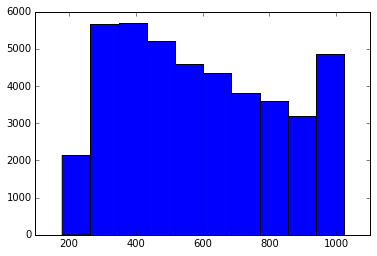

In [14]:
plt.hist([np.amax(sig_cth.get_events(evt)["CTHHit.fMCPos.fE"]) \
          for evt in range(sig_cth.n_events)])
plt.show()

### Only keep events with hits in both CTH and CDC

In [15]:
passed_events = np.intersect1d(sig_cth.get_signal_hits()[sig_cth.key_name], 
                               sig_cdc.get_signal_hits()[sig_cdc.key_name])
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)
print len(passed_events)

20759


In [16]:
print len(np.intersect1d(np.random.randint(0, 100000, 43087), np.random.randint(0, 100000, 52639)))

14245


In [17]:
print passed_events[:10]

[ 0  4  8 14 33 38 39 41 44 46]


In [18]:
t_hit_cth = np.zeros(sig_cth.n_events)
for event in range(sig_cth.n_events):
    event_hits = sig_cth.get_events(event)
    t_hit = 100000000000
    for channel in np.unique(event_hits["CTHHit.fChannel"]):
        chan_hits = sig_cth.filter_hits(event_hits, "CTHHit.fChannel", values=channel)
        t_hit_here = sig_cth.filter_hits(chan_hits, "CTHHit.fCharge", 
                                    values=np.amax(chan_hits["CTHHit.fCharge"]))["CTHHit.fMCPos.fE"]
        t_hit_here = np.amin(t_hit_here)
        t_hit = min(t_hit, t_hit_here)
    t_hit_cth[event] = t_hit

In [19]:
min_sig_time_cdc = np.array([np.amin(sig_cdc.get_signal_hits(event)["CDCHit.fMCPos.fE"])\
                                        for event in range(sig_cdc.n_events)])
max_sig_time_cdc = np.array([np.amax(sig_cdc.get_signal_hits(event)["CDCHit.fMCPos.fE"])\
                                        for event in range(sig_cdc.n_events)])
avg_sig_time_cdc = np.array([np.average(sig_cdc.get_signal_hits(event)["CDCHit.fMCPos.fE"])\
                                        for event in range(sig_cdc.n_events)])

In [20]:
min_sig_time_cth = np.array([np.amin(sig_cth.get_signal_hits(event)["CTHHit.fMCPos.fE"])\
                                        for event in range(sig_cth.n_events)])
max_sig_time_cth = np.array([np.amax(sig_cth.get_signal_hits(event)["CTHHit.fMCPos.fE"])\
                                        for event in range(sig_cth.n_events)])
avg_sig_time_cth = np.array([np.average(sig_cth.get_signal_hits(event)["CTHHit.fMCPos.fE"])\
                                        for event in range(sig_cth.n_events)])

In [21]:
cdc_array = min_sig_time_cdc
cth_array = min_sig_time_cth

print np.average(cdc_array)
print np.average(cth_array)

#plt.scatter(cdc_array[::10], cth_array[::10])
#plt.show()

residual_1 = sum(np.square(cdc_array - cth_array))

sum_residual = 0
n_resamples = 100

for i in range(n_resamples):
    residual_2 = sum(np.square(cdc_array - np.random.permutation(cth_array)))
    sum_residual += (residual_2 - residual_1)
print sum_residual/n_resamples

1013.45203684
508.876535479
-13975889.1803


### Smear the hits by the bunch width

In [22]:
random_time_smear = np.random.randint(-50,50, size=len(passed_events))

In [23]:
cdc_time_smear = random_time_smear[sig_cdc.hits_to_events]
cth_time_smear = random_time_smear[sig_cth.hits_to_events]

In [24]:
sig_cdc.data["CDCHit.fMCPos.fE"] += cdc_time_smear
sig_cth.data["CTHHit.fMCPos.fE"] += cth_time_smear

### Add the drift time to the CDC hits

In [25]:
sig_cdc.data["CDCHit.fMCPos.fE"] += sig_cdc.data["CDCHit.fDriftTime"]

## Cuts on the Signal Tracks

In [26]:
# Define cuts to use
n_hits_cut = True
layer_cut = True
timing_cut = True
use_cth_cut = True

### Fiducial Time Window Cuts

In [27]:
if timing_cut:
    # Apply the timing filter
    print "Before timing cut"
    before_cdc_nhits = sig_cdc.n_hits
    before_cth_nhits = sig_cth.n_hits
    print "CTH Hits: {}".format(before_cth_nhits)
    print "CDC Hits: {}".format(before_cdc_nhits)
    sig_cth.trim_hits(variable="CTHHit.fMCPos.fE", greater_than=500, less_than=1170)
    sig_cdc.trim_hits(variable=sig_cdc.time_name, greater_than=500, less_than=1620)
    print "After timing cut"
    print "CTH Hits: {0}, {1:.2f}".format(sig_cth.n_hits, float(sig_cth.n_hits)/before_cth_nhits)
    print "CDC Hits: {0}, {1:.2f}".format(sig_cdc.n_hits, float(sig_cdc.n_hits)/before_cdc_nhits)

Before timing cut
CTH Hits: 10020536
CDC Hits: 1812246
After timing cut
CTH Hits: 5122227, 0.51
CDC Hits: 919233, 0.51


In [28]:
passed_events = np.intersect1d(sig_cth.get_events()[sig_cth.key_name], 
                               sig_cdc.get_events()[sig_cdc.key_name])
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)
print len(passed_events)

6385


### Cuts on CTH

In [29]:
# Filter for CTH in time window.  Get the time
print sig_cth.n_events
trigger_events = []
for evt in range(sig_cth.n_events):
    sig_hits = sig_cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        trigger_events.append(evt)
trigger_events = np.array(trigger_events)
print "Events that pass CTH Trigger: {}".format(len(trigger_events))

6385
Events that pass CTH Trigger: 5768


### Cuts on CyDet

In [30]:
# Filter for max layer is five
max_layer = []
for evt in range(sig_cdc.n_events):
    these_layers = sig_cdc.geom.point_layers[sig_cdc.get_sig_wires(evt)]
    if len(sig_cdc.get_sig_wires(evt)) != 0:
        max_layer.append(np.max(these_layers))
    else:
        max_layer.append(-1)
max_layer = np.array(max_layer)
good_max_layer = np.where(max_layer >= 4)[0]
print "Passed Max Layer {}".format(len(good_max_layer))

Passed Max Layer 5333


In [31]:
# Filter for number of signal hits
n_signal_hits  = np.array([len(sig_cdc.get_signal_hits(evt)) 
                         for evt in range(sig_cth.n_events)])
n_signal_hits = np.array(n_signal_hits)
good_n_hits = np.where(n_signal_hits >= 30)[0]
print "Passed Good Number of Hits : {}".format(len(good_n_hits))

Passed Good Number of Hits : 5402


### Apply the cuts

In [32]:
if use_cth_cut:
    passed_events = np.intersect1d(passed_events, sig_cth.get_events(trigger_events)[sig_cth.key_name])
    print "Removed due to CTH Trigger {}".format(sig_cth.n_events - len(trigger_events))
if layer_cut:
    passed_events = np.intersect1d(passed_events, sig_cdc.get_events(good_max_layer)[sig_cdc.key_name])
    print "Removed due to Layer Cut {}".format(sig_cdc.n_events - len(good_max_layer))
if n_hits_cut:
    passed_events = np.intersect1d(passed_events, sig_cdc.get_events(good_n_hits)[sig_cdc.key_name])
    print "Removed due to N Hits Cut {}".format(sig_cdc.n_events - len(good_n_hits))

Removed due to CTH Trigger 617
Removed due to Layer Cut 1052
Removed due to N Hits Cut 983


In [33]:
print "After All Cuts {}".format(len(passed_events))

After All Cuts 4514


In [34]:
sig_cdc.trim_hits(sig_cdc.key_name, values=passed_events)
sig_cth.trim_hits(sig_cth.key_name, values=passed_events)

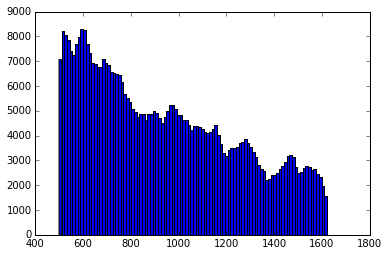

In [35]:
plt.hist(sig_cdc.get_events()[sig_cdc.time_name], bins=100)
show()

## Prepare the data

In [36]:
import pandas
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

In [37]:
back_sample = "/vols/comet00/users/elg112/ICEDUST"\
              "/local_storage/MC3b_tree"\
              "/loose_timing_cut/event_root"\
              "/1_2500_merged_cdc_sum_hit.root"

In [51]:
back_cdc = CyDetHits(back_sample, 
                     tree="COMETEventsSummary",
                     signal_coding=[-1], 
                     hit_type_name="Track.fTrackID",
                     branches=these_branches)

In [52]:
for event in range(back_cdc.n_events):
    all_event_ids = np.unique(back_cdc.get_events(event)[back_cdc.key_name])
    if len(all_event_ids) != 1:
        print event
    elif all_event_ids[0] - event != 1:
        print event

In [53]:
back_cdc.all_branches

['CDCHit.fDriftTime',
 'CDCHit.fDriftDist',
 'CDCHit.fTrack.fTrackID',
 'CDCHit.fEventNumber',
 'CDCHit.fhits_index',
 'CDCHit.fevent_index',
 'CDCHit.fvol_id',
 'CDCHit.fCharge',
 'CDCHit.fMCPos.fE',
 'CDCHit.fTrigTime']

In [57]:
if timing_cut:
    # Apply the timing filter
    print "CyDet Hits: {}".format(back_cdc.n_hits)
    back_cdc.trim_hits(variable=back_cdc.time_name, less_than=1620, greater_than=500)
    print "CyDet Hits: {}".format(back_cdc.n_hits)
    print "Back Events : {}".format(back_cdc.n_events)

CyDet Hits: 1697759
CyDet Hits: 1697759
Back Events : 2494


In [56]:
print len(back_cdc.get_signal_hits())

0


### Set the trigger time

In [ ]:
# Set the trigger times
trig_time_evt = []
for evt in range(sig.n_events):
    sig_hits = sig_cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        this_trig_time = sig_hits["fCTHHit.fMCPos.fE"][0]
        trig_time_evt.append(this_trig_time)
        sig_cdc.data[sig_cdc.trig_name][sig_cdc.event_to_hits[evt]] = this_trig_time
        back_cdc.data[back_cdc.trig_name][back_cdc.event_to_hits[evt]] = this_trig_time

In [ ]:
plt.hist(trig_time_evt)

In [ ]:
right_neighs = numpy.array([back_cdc.geom.shift_wire(wire, 1) for wire in range(back_cdc.geom.n_points)])
left_neighs = numpy.array([back_cdc.geom.shift_wire(wire, -1) for wire in range(back_cdc.geom.n_points)])

In [ ]:
# Energy deposits
deposits = numpy.vstack(back_cdc.get_energy_deposits(i) \
                        + sig_cdc.get_energy_deposits(i) \
                        for i in range(n_events))
deposits *= 100 # to avoid small numbers for GBRT

In [26]:
# Figure out coincidence
sig_time =  numpy.vstack(sig_cdc.get_hit_time(i)  for i in range(n_events)) # + 700.
hit_time =  numpy.vstack(back_cdc.get_hit_time(i) for i in range(n_events))
# Flatten at first
sig_time = sig_time.flatten()
hit_time = hit_time.flatten()
# Find signal hits
sig_mask = sig_time != 0
# Find background hits
hit_mask = hit_time != 0
# Find coincidence
both = np.logical_and(sig_mask, hit_mask)
# Find when coincidence meant signal was sooner
sig_sooner = sig_time < hit_time
# Create masks for coincidence 
both_take_sig = np.logical_and(both, sig_sooner)
both_take_hit = np.logical_and(both, np.logical_not(sig_sooner))

In [27]:
print memory_usage()
del sig_time, hit_time
print memory_usage()

[3714.4609375]
[3517.83984375]


In [28]:
# Time after triggering that signal waveforms starts
sig_rel_time =  numpy.vstack(sig_cdc.get_relative_time(i)  for i in range(n_events))
hit_rel_time =  numpy.vstack(back_cdc.get_relative_time(i) for i in range(n_events))
# Flatten at first
sig_rel_time = sig_rel_time.flatten()
hit_rel_time = hit_rel_time.flatten()
# Start with signal hit values, with the rest empty
rel_time = sig_rel_time + hit_rel_time
# Overlay masked background hits, where earlier signal hits are removed by mask
rel_time[both_take_sig] = sig_rel_time[both_take_sig]
rel_time[both_take_hit] = hit_rel_time[both_take_hit]
# Reshape back
rel_time = rel_time.reshape((n_events,-1))

In [29]:
print memory_usage()
del sig_rel_time, hit_rel_time
print memory_usage()

[3714.4609375]
[3517.83984375]


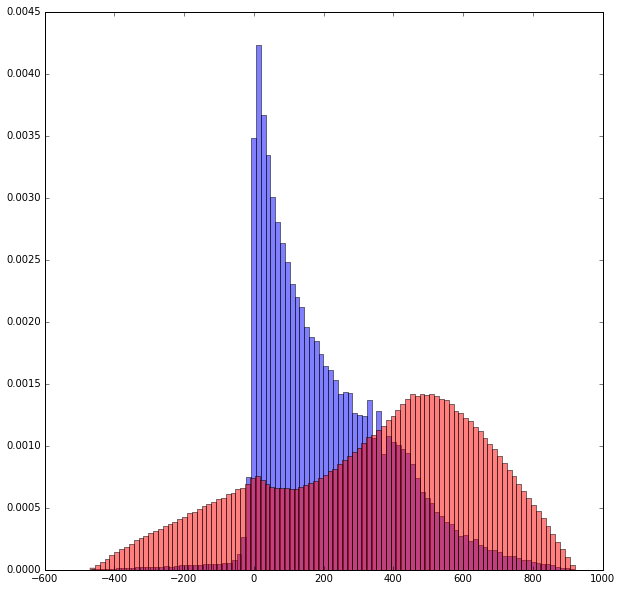

436222
2181683


In [30]:
figsize(10,10)
plt.hist(rel_time.flatten()[sig_mask], bins=100,  color='blue', alpha=0.5, normed=True)
plt.hist(rel_time.flatten()[hit_mask], bins=100,  color='red', alpha=0.5, normed=True)
show()
print len((rel_time.flatten()[sig_mask]))
print len((rel_time.flatten()[hit_mask]))

In [31]:
# Truth Values
sig_labels = numpy.vstack(sig_cdc.get_hit_types(i) for i in range(n_events))
hit_labels = numpy.vstack(back_cdc.get_hit_types(i) for i in range(n_events)) 
# Flatten at first
sig_labels = sig_labels.flatten()
hit_labels = hit_labels.flatten()
# Define the overall relative time
labels =  hit_labels + sig_labels
# Factor in signal (and coincidence)
labels[both_take_sig] = sig_labels[both_take_sig]
labels[both_take_hit] = hit_labels[both_take_hit]
# Reshape bacl
labels = labels.reshape((n_events,-1))

In [32]:
# Layer ID of hit wires
layer_id = numpy.vstack(geom.point_rhos for i in range(n_events))

In [33]:
labels.shape, deposits.shape

((5750, 4482), (5750, 4482))

In [34]:
## Look up table to map from events to hits
event_to_hit_look = np.arange(n_events*geom.n_points).reshape(n_events, -1)

In [35]:
from sklearn.cross_validation import train_test_split
rest, sample_3 = train_test_split(range(len(labels)), train_size=0.6, test_size=0.3)
sample_1, sample_2 = train_test_split(rest, train_size=0.5, test_size=0.5)

In [36]:
print memory_usage()
del sig, hits, sig_cdc, sig_cth, back_cdc
print memory_usage()

[4304.35546875]
[3514.4921875]


In [37]:
data_1, data_2, data_3 = pandas.DataFrame(), pandas.DataFrame(), pandas.DataFrame()

for data_samp, samp in zip([data_1, data_2, data_3],\
                           [sample_1, sample_2, sample_3]):
    # Deposit features
    data_samp['deposit'] = (deposits * 100)[samp].flatten()
    data_samp['r_deposit'] = (deposits * 100)[:, right_neighs][samp].flatten()
    data_samp['l_deposit'] = (deposits * 100)[:, left_neighs][samp].flatten()
    data_samp['layer_id'] = layer_id[samp].flatten()

In [38]:
print memory_usage()
del deposits, layer_id
print memory_usage()

[3514.6796875]
[3318.0625]


In [39]:
for data_samp, samp in zip([data_1, data_2, data_3],\
                           [sample_1, sample_2, sample_3]):
    # Time feature
    data_samp['rel_time'] = rel_time[samp].flatten()
    data_samp['r_rel_time'] = rel_time[:, right_neighs][samp].flatten()
    data_samp['l_rel_time'] = rel_time[:, left_neighs][samp].flatten()

In [40]:
print memory_usage()
del rel_time
print memory_usage()

[3377.0546875]
[3377.0546875]


In [41]:
for data_samp, samp in zip([data_1, data_2, data_3],\
                           [sample_1, sample_2, sample_3]):
    # Truth values
    data_samp['labels'] = labels[samp].flatten()
    data_samp['is_signal'] =  numpy.take([0, 1, 0], labels.astype(int))[samp].flatten()

In [42]:
print memory_usage()
del labels
print memory_usage()

[3554.0234375]
[3357.40234375]


In [43]:
print list(data_1.columns.astype(str))

['deposit', 'r_deposit', 'l_deposit', 'layer_id', 'rel_time', 'r_rel_time', 'l_rel_time', 'labels', 'is_signal']


In [44]:
# Define Data
train_features = list(data_1.columns[:-2])
n_feats = len(data_1.columns)
feature_labels = list(data_1.columns)

## Classify Data

In [45]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc

In [46]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
# Add the GBDT
factory.add_classifier('Local and Neighbour Features', neigh_gbdt)

In [47]:
# Train the classifier
factory.fit(mask(data_1), mask(data_1)['is_signal'])
pass

model Local and Neighbour Features was trained in 255.01 seconds
Totally spent 255.01 seconds on training


In [48]:
print memory_usage()
del data_1
print memory_usage()

[3895.859375]
[3364.98046875]


In [49]:
# Print these predictions
# TODO clean up pred_2, pred_evt_2
pred_2, pred_evt_2 = predict_classifier(neigh_gbdt, data_2)

In [50]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = (mask(data_2)['labels'] != 0) * abs(mask(data_2)['is_signal'] - pred_2) ** 2

In [51]:
print roc_auc_score(mask(data_2)['is_signal'], pred_2)
print roc_auc_score(mask(data_2)['is_signal'], pred_2, sample_weight=problem_weights_2)

0.990943055018
0.190952485317


In [52]:
from tracking import HoughSpace

default = [[31.5, 34, 34.5, 2]]
submatrices = []

# Define even and odd layer wires
even_wires = geom.point_pol != 1
odd_wires = geom.point_pol == 1

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(geom, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [53]:
from tracking import HoughTransformer, HoughShifter
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     pred_evt_2, alpha_max=2., alpha_rw=2.)

In [54]:
# Predict for third sample
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

# Get the hough results
# TODO clean up pred_2, pred_evt_2
hough_result_2, hough_image_2 = hough_transformer.transform(pred_evt_2)
hough_result_3, hough_image_3 = hough_transformer.transform(pred_evt_3)

In [55]:
# Do the first transform to get the hough space that needs to be aligned
aligner = HoughTransformer(new_correspondence, hough.norm_track_neighs, pred_evt_2, alpha_rw=2., alpha_max=2.)
_ , to_align_3 = aligner.transform(pred_evt_3)

In [56]:
# Shift this hough space to get the even and odd layers agreeing
hough_shifter_2 = HoughShifter(hough, 10, -10)
hough_shifter_3 = HoughShifter(hough, 10, -10)

# Get the images
hough_image_even_3 = to_align_3[:,:hough.track.n_points]
hough_image_odd_3 = to_align_3[:,hough.track.n_points:]
# Fit the shifter
ideal_rotate_3, integral_even_3, integral_odd_3 =\
    hough_shifter_3.fit_shift(hough_image_even_3, hough_image_odd_3)
# Shift the result
shift_pred_evt_3 = hough_shifter_3.shift_result(pred_evt_3)
shift_labels_3 = hough_shifter_3.shift_result(data_3['labels'].reshape(-1, geom.n_points))

In [57]:
# Add these as features
data_2['Hough'] = hough_result_2.flatten()
data_3['Hough'] = hough_result_3.flatten()

In [58]:
# Add this to the feature list
train_features_full = train_features + ['Hough']

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=train_features_full) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=['deposit'])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Hough, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [59]:
# Train the classifier
factory.fit(mask(data_2), mask(data_2)['is_signal'])
pass

model Local and Neighbour Features was trained in 453.03 seconds
model Hough, Local and Neighbour Features was trained in 253.07 seconds
model Energy Deposition was trained in 170.29 seconds
Totally spent 876.38 seconds on training


In [60]:
# Test it on the last set of data
pred_final_diag_3 = factory.test_on(mask(data_3), mask(data_3)['is_signal'])
pred_final_3, pred_final_evt_3 = predict_classifier(hough_gbdt, data_3)
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

In [61]:
# TODO clean this up
from collections import OrderedDict

figsize(6.4,6.4) 
feat_label_dict = OrderedDict([
            ('l_rel_time' , "Left Timing"),  
            ('r_rel_time' , "Right Timing"),
            ("layer_id" , "R Distance"), 
            ('r_deposit' , 'Right Energy'), 
            ('l_deposit' , 'Left Energy'), 
            ('rel_time' , "Timing"),
            ('deposit' , 'Energy'), 
            ('Hough' , r"Hough, $W_j''$")
    ])

def plot_feature_importance(rep_classifier, feat_label_dict):
    feat_import = rep_classifier.get_feature_importances()
    feat_import = feat_import.sort("effect", ascending=False)
    ax = plt.subplot(111)
    ax.bar( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
    ax.set_xticks(np.arange(len(feat_import.values))+0.5)
    ax.minorticks_on()
    ax.set_ylabel("Normalized Relative Usage")
    ax.set_title("Feature Importance")
    ax.autoscale()
    ax.grid(b=True, which='major', axis='y' ,color='grey', linestyle='--')
    ax.grid(b=True, which='minor', axis='y' , color='grey', linestyle=':')
    ordered_labels = OrderedDict((key, feat_label_dict[key]) for key in feat_import.index.values)
    ax.set_xticklabels(ordered_labels.values(),  rotation='vertical')
    ax.set_yticklabels(["{:.0f}%".format(tick*100) for tick in ax.get_yticks()])
    return ax

def plot_feature_correlations(rep_factory, feat_label_dict):
    corr = pred_final_diag_3.features_correlation_matrix(features=train_features+["Hough"],
                                tick_labels=[feat_label_dict[key] for key in train_features_full])
    corr.fontsize = 15
    corr.cmap = "RdBu"
    return corr.plot()

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


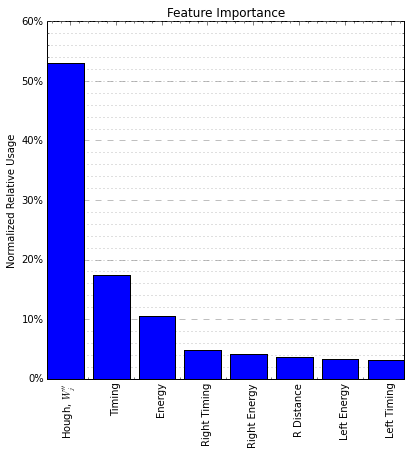

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


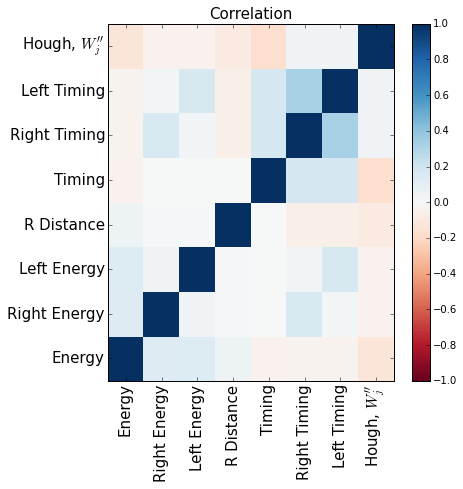

In [62]:
hough_level = factory["Hough, Local and Neighbour Features"]
plot_feature_importance(hough_level, feat_label_dict)
show()
plot_feature_correlations(factory, feat_label_dict)
show()

(<matplotlib.axes._subplots.AxesSubplot at 0x2b0707d0>,
 <matplotlib.figure.Figure at 0x71e1e50>)

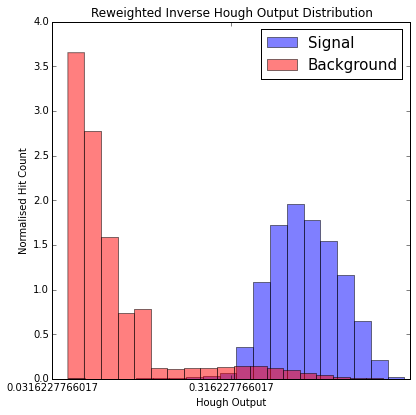

In [63]:
plot_feature( (data_3['Hough'].values+0.1), data_3['labels'].values, 
             xlabel="Hough Output", ylabel="Normalised Hit Count", xlog=True,
            title="Reweighted Inverse Hough Output Distribution", nbins=20)

In [64]:
print roc_auc_score(mask(data_3)['is_signal'], pred_final_3)

0.997283854588


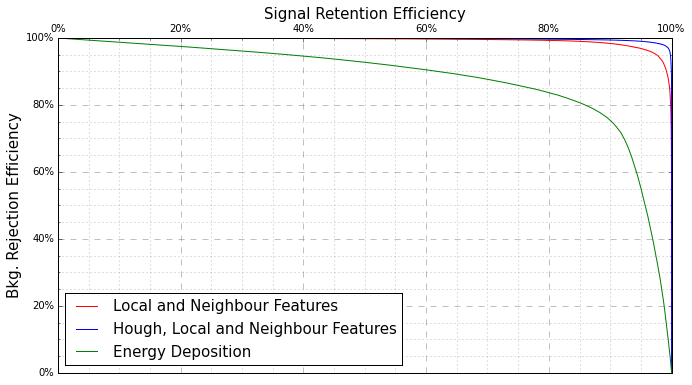

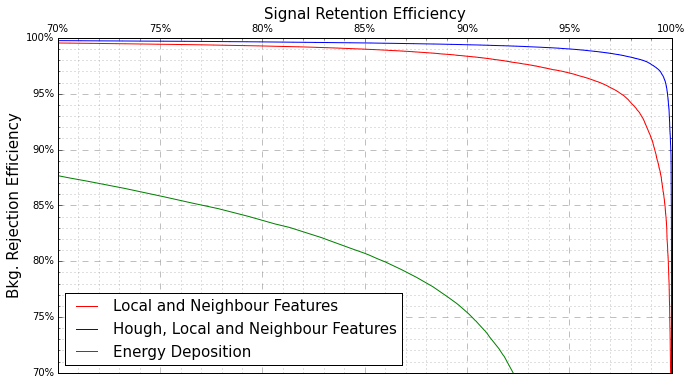

In [65]:
figsize(11,6) 
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=False)
#plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc.png", bbox_inches="tight")
show()
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=True)
#plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc_zoom.png", bbox_inches="tight")
show()

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


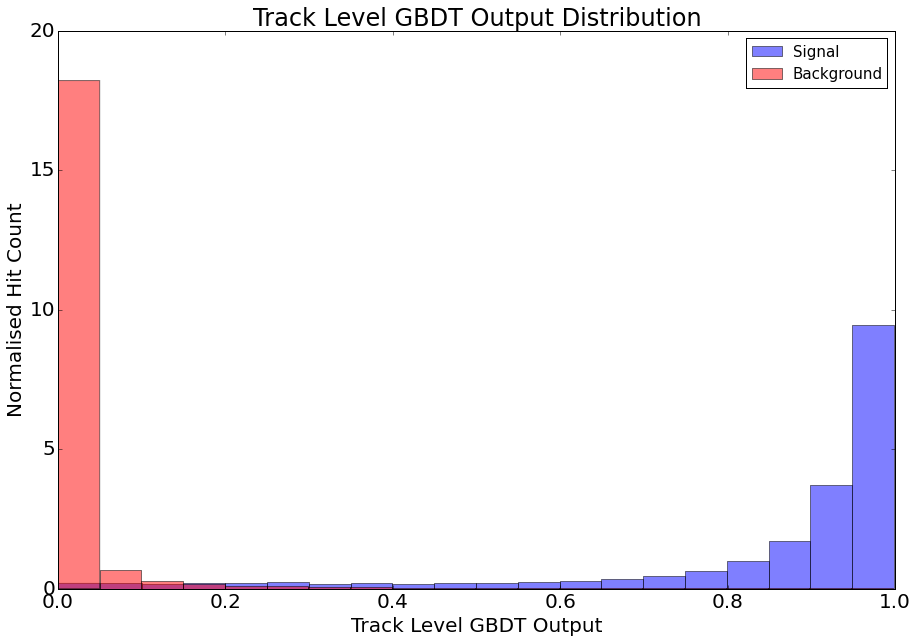

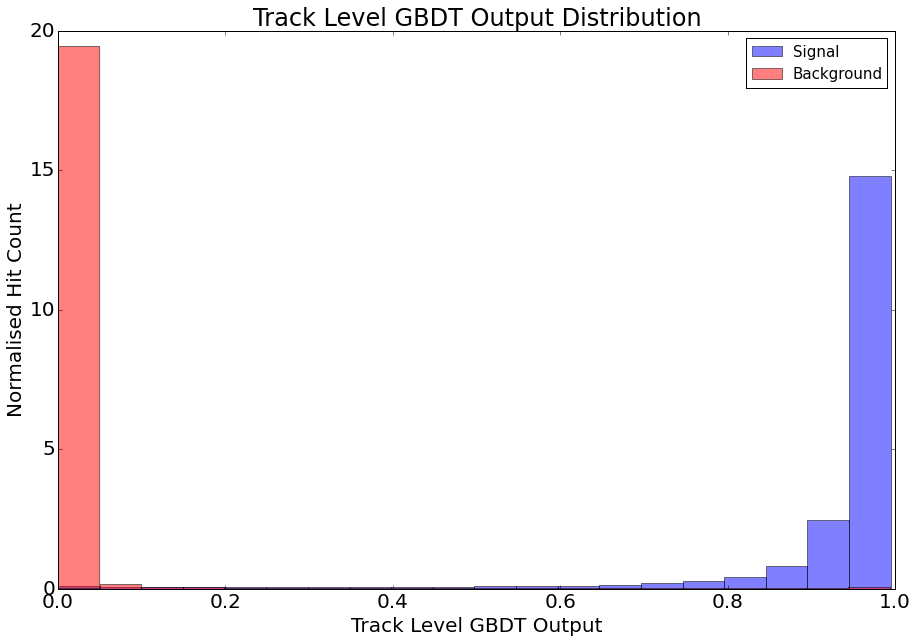

In [66]:
figsize(15,10)
plot_set_font(size=20)
plot_feature( pred_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count", 
            title="Track Level GBDT Output Distribution", nbins=20)
show()
plot_feature( pred_final_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()

In [67]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_3, sample_weight=problem_weights_3)

0.992753122642
0.148320262942


In [68]:
# Event information\
event = 1000
add_trans = True
save = False
savedir = "/vols/comet00/users/elg112/ICEDUST/track-finding-yandex/sakamoto_example/"

evt_hits = event_to_hit_look[event]
to_plot = data_3["labels"].values[evt_hits]
hough_output = data_3["Hough"].values[evt_hits]
plot_hough_image_3 = hough_image_3[event,:hough.track.n_points] + hough_image_3[event,hough.track.n_points:]

# Shifted plot information
shift_plot = shift_labels_3[event]

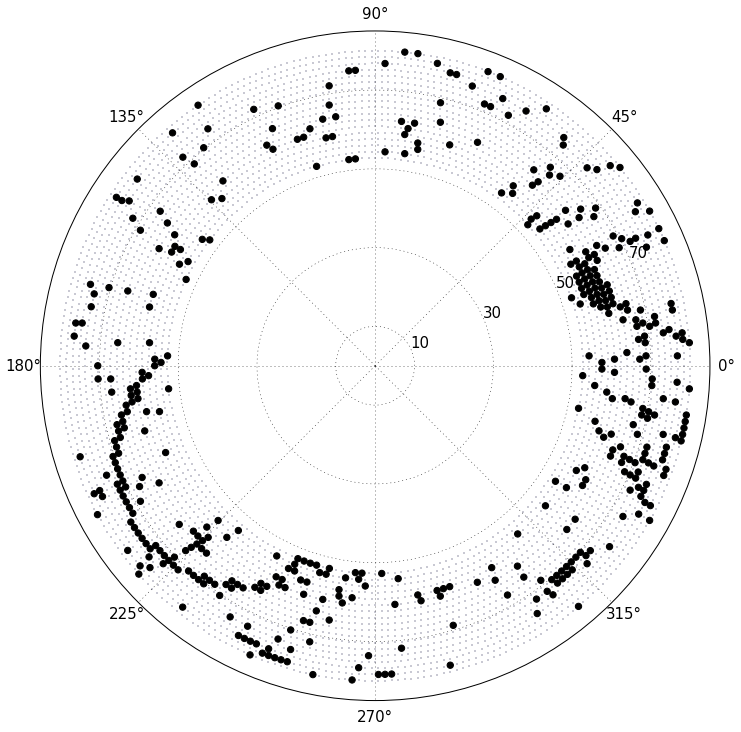

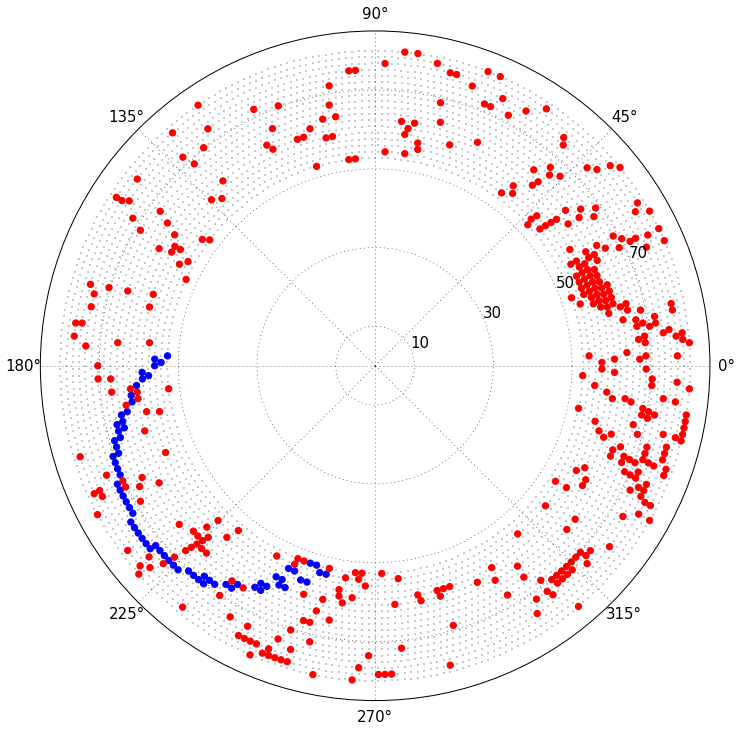

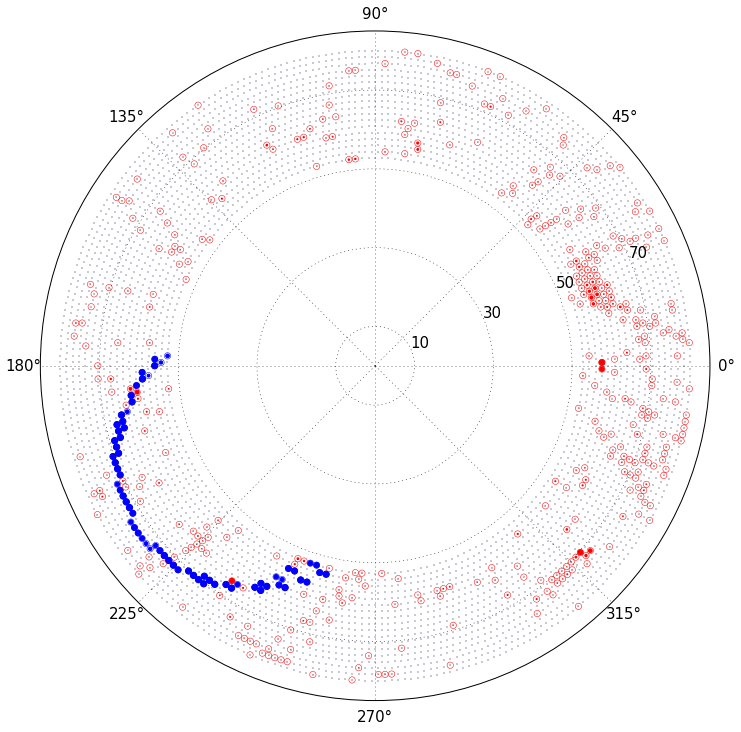

Length of draw tracks are 65


/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


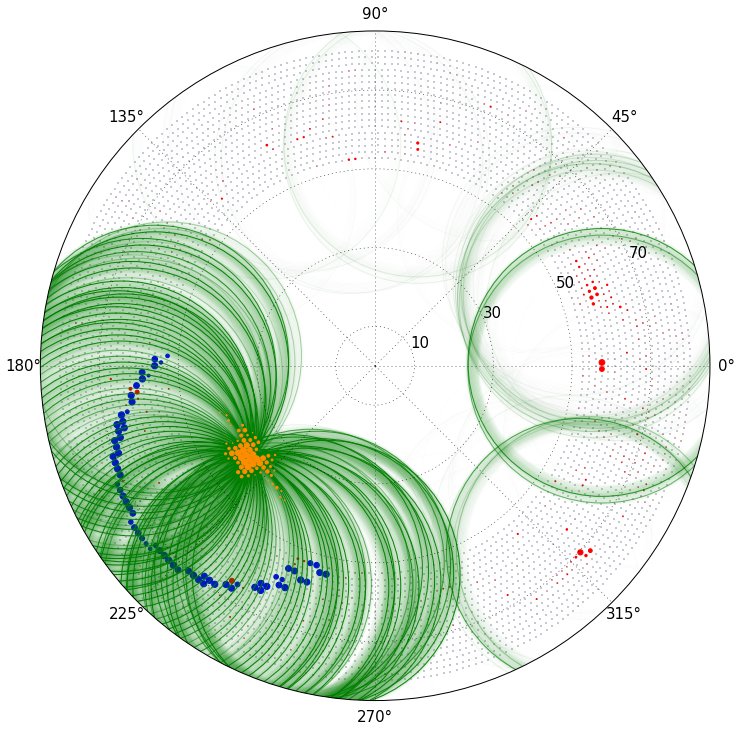

Length of draw tracks are 67


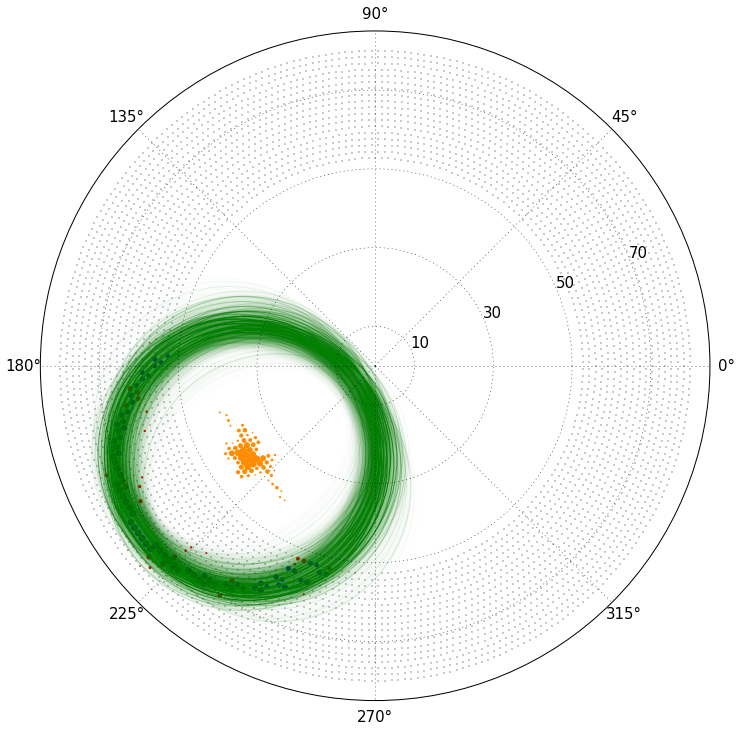

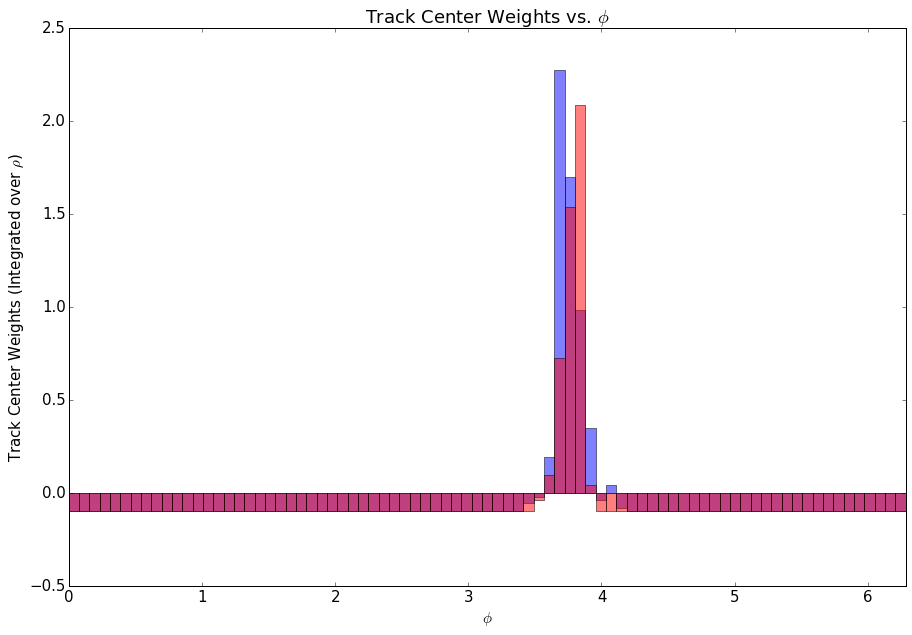

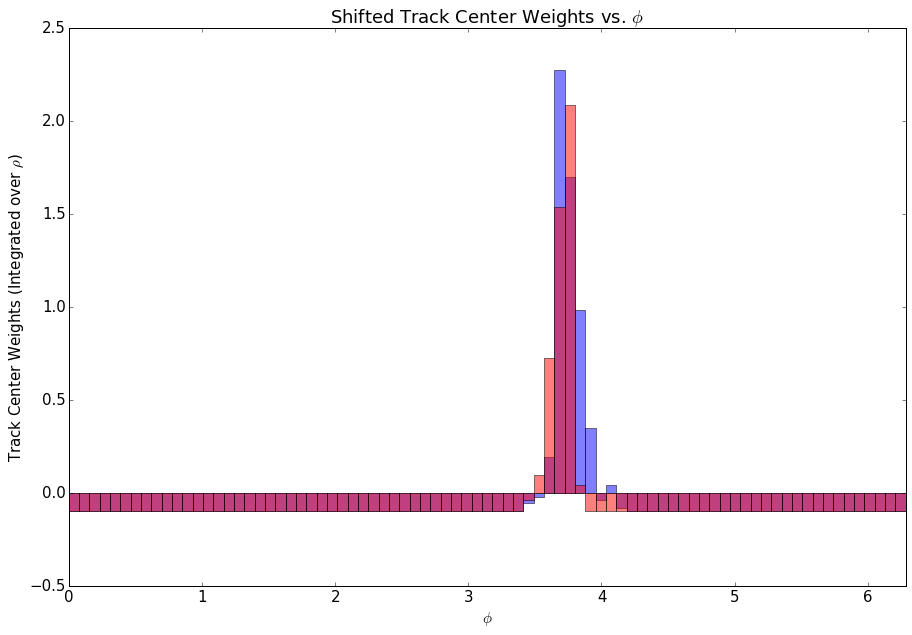

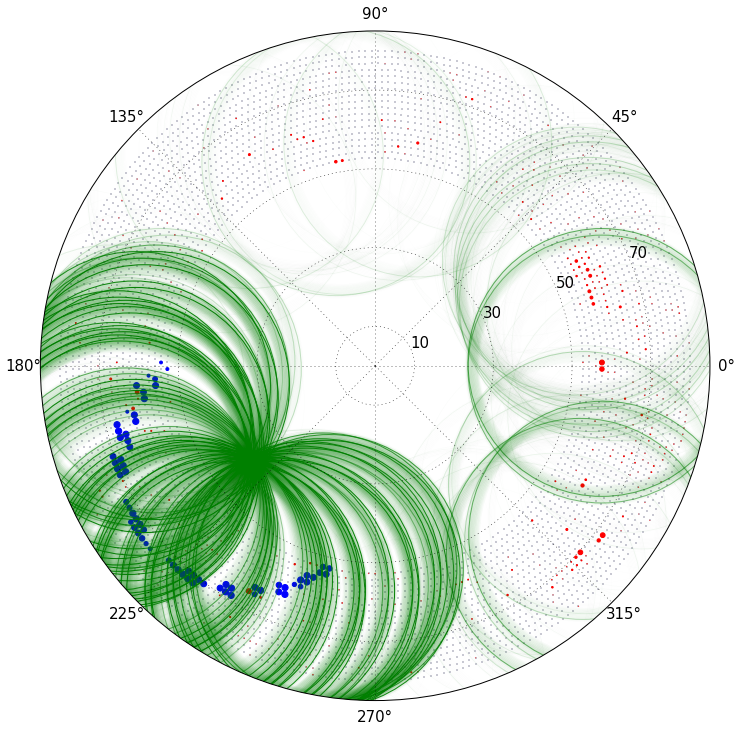

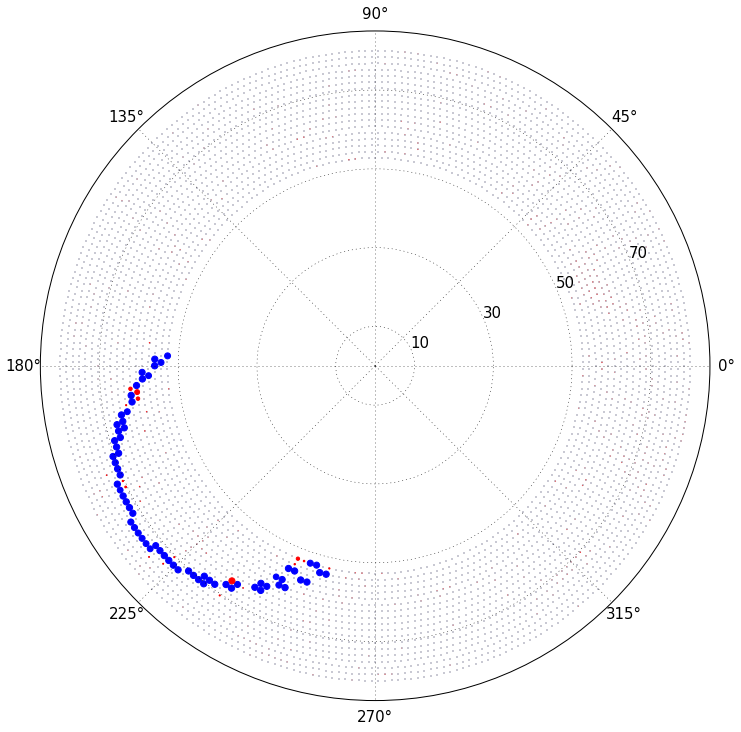

In [69]:
# Basic output
plot_output(to_plot, geom, sig_color='black', bkg_color='black', )
if save:
    plt.savefig(savedir+"plot_event_bw.png", bbox_inches='tight')
show()

plot_output(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_event.png", bbox_inches='tight')
show()

# First GBDT output
plot_output(to_plot, geom, size=plot_norm_size(pred_evt_3[event,:]))
plot_add_outlines(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

# Hough output
plot_output(to_plot, geom, size=plot_norm_size(pred_evt_3[event,:]), add_transform=add_trans)
plot_add_tracks(geom, hough, size=plot_norm_size(plot_hough_image_3,40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight')
show()

# Inverse Hough output
plot_output(to_plot, geom, size=plot_norm_size(hough_output))
plot_add_tracks(geom, hough, size=plot_norm_size(plot_hough_image_3,40), add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight')
show()    

# Shift in Hough Space
# TODO magic number here
plot_hough_shift(integral_even_3[event,:], integral_odd_3[event,:], 
                 hough_shifter_3.rotate_index[event]+hough_shifter_3.lower_lim)
show()

# Hough output
plot_output(shift_plot, geom, size=plot_norm_size(shift_pred_evt_3[event,:]), add_transform=add_trans)
#plot_add_tracks(geom, hough, size=plot_norm_size(shift_hough_image,40))
if save:
    plt.savefig(savedir+"plot_shft_hough.png",  bbox_inches='tight')
show()

# Inverse Hough output
#plot_output(shift_plot, geom, size=plot_norm_size(shift_hough_output))
#plot_add_tracks(geom, hough, size=plot_norm_size(shift_hough_image,40), add_transform=add_trans,
#                tolerance=0.00)
#if save:
#    plt.savefig(savedir+"plot_shft_inv_hough.png", bbox_inches='tight')
#show()

# Final
plot_output(to_plot, geom, size=plot_norm_size(pred_final_evt_3[event,:]))
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

In [70]:
# TODO 
# Plots for Louis

# Penalize for not being the closest point to the fit



# Belle-II literature
# multiple radii
# optimize hough to improve track purity, use RANSAC to shed background islands
# 

#TODO Offline Analysis
# WEDS clean up RANSAC implimentation
# WEDS use shifted hough in RANSAC implimentation
# THURS penalize on no hits for RANSAC
# THURS change sampling probability via GBDT score
# THURS change scoring weight by GBDT score
# FRI check results for mulitple radii, no optimization
# FRI check results for varying hit efficiencies, no optimization


# In[73]:

#TODO Online
# TUES Rebuild notebook for new sample
# TUES Integrate trigger signal in
# TUES Reevaluate the flow of the algorithm


# In[74]:

# MC PRODUCTION
# Timing in Prod. Sec.
#  Determine IO and CPU time for current jobs
#  Determine best cuts to make (most obvious ones anyway)
# ECAL hits
#  After CM18
# Cross-Check occupancy
#  Generate large enough CyDet sample and check occupancy
#  Perhaps do this locally, or atleast the merging part


# In[75]:

# NOTES
## Shifting to align image in hough space must 
#  play well with the placticity already 
#  implimented in the algorithm.  Adjust reweighting
## Try reweighting background hits close to signal hits
#  as worse when we do the track level GBDT algo.  Rid
#  background islands at RANSAC level.

